In [1]:
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, UpSampling2D, Cropping2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score


In [2]:
class PINE(object):
    model_name = "pine"     # name for checkpoint
#     dataset_name = "mnist"

    def __init__(self, batch_size, dataset_name):

        self.latent_dim = 100 
        self.batch_size = batch_size
        self.learning_rate_main_model = 0.0001
        self.learning_rate_interpreter = 0.0001
        self.checkpoint_dir = 'checkpoint'
        self.dataset_name = dataset_name
 
        if dataset_name == 'mnist':
            # parameters
            self.channels = 1            
            self.img_rows = 28
            self.img_cols = 28
            self.output_height = 28
            self.output_width = 28
            self.img_shape = (self.img_rows, self.img_cols, self.channels)
            self.y_dim = 10        

            # train
            self.learning_rate = 0.0001
            self.beta1 = 0.5

            # test
            self.sample_num = 64  
            self.len_discrete_code = 10

            # load mnist
            # Load the dataset
            (X_train,y_train), (X_test, y_test) = mnist.load_data()

            # Rescale -1 to 1
            X_train = X_train / 255.
            self.X_train = np.expand_dims(X_train, axis=3)


            X_test = X_test / 255.
            self.X_test = np.expand_dims(X_test, axis=3)

            y_vec = np.zeros((len(y_train), 10), dtype=np.float)
            for i, label in enumerate(y_train):
                y_vec[i, y_train[i]] = 1.0
            self.y_vec = y_vec
            y_vec_test = np.zeros((len(y_test), 10), dtype=np.float)
            for i, label in enumerate(y_test):
                y_vec_test[i, y_test[i]] = 1.0            
            self.y_vec_test = y_vec_test


        elif dataset_name == 'cifar10':
            # parameters
            self.channels = 3            
            self.img_rows = 32
            self.img_cols = 32
            self.output_height = 32
            self.output_width = 32
            self.img_shape = (self.img_rows, self.img_cols, self.channels)      
            self.y_dim = 10        


            # Loss terms coefficients
            self.c1 = 10000
            self.c2 = 10000
            self.c3 = 1000000
            self.c4 = 1000
            # train
            self.learning_rate = 0.0001
            self.beta1 = 0.5

            # test
            self.sample_num = 64  

            # load mnist
            self.data_X, self.data_X_test, self.data_y, self.data_y_test = load_cifar10(self.dataset_name)

            # get number of batches for a single epoch
            self.num_batches = len(self.data_X) // self.batch_size
            self.kcc = tf.keras.losses.CategoricalCrossentropy()        
        # Build and compile the interpreter
        self.interpreter = self.build_interpreter()

        # Build the mian model
        self.main_model = self.build_main_model()

    
#            ___________
#           /           \
#          / MAIN  MODEL \
#         /_______________\        
        
    def build_main_model(self):


        imgs = tf.keras.Input(shape=(28, 28, 1), name="img")
        x = tf.keras.layers.Conv2D(64, 4, activation=LeakyReLU(0.2), strides=2, padding='same')(imgs)
        x = tf.keras.layers.Conv2D(128, 4, activation=LeakyReLU(0.2), strides=2, padding='same')(x)
        x = BatchNormalization(axis=-1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(1024, activation=LeakyReLU(0.2))(x)
        x = BatchNormalization(axis=-1)(x)
        out = tf.keras.layers.Dense(10, activation="softmax")(x)
        model = tf.keras.Model(inputs = imgs, outputs = out)

        print(model.summary())
        return model

    
#          _________________
#          \               /
#           \             /
#            \           /
#             INTERPRETER
#            /           \
#           /             \
#          /_______________\
    
    
    def build_interpreter(self):

        # # Encoder
        encoder_input = tf.keras.Input(shape=(28, 28, 1), name="img")
        x = tf.keras.layers.Conv2D(64, 4, activation="relu",strides=2, padding='same')(encoder_input)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(32)(x)
         # # Decoder
        x = tf.keras.layers.Dense(64 * 14 * 14, activation="relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = tf.keras.layers.Reshape((14, 14, 64))(x)
        out = tf.keras.layers.Conv2DTranspose(1, 4, activation="sigmoid",strides=2, padding='same')(x)


        model = tf.keras.Model(inputs = encoder_input, outputs = out)


        print(model.summary())

        return model
    
    def main_model_loss_fn(self, out_img):
        CatCrossEnt = tf.keras.losses.CategoricalCrossentropy()
        return CatCrossEnt(self.y, out_img)  
    def interpreter_loss_fn(self, ints, out_int, imgs, out_img):
        c1 = 10000
        c2 = 10000
        c3 = 15000
        CatCrossEnt = tf.keras.losses.CategoricalCrossentropy()
        int_error = tf.sqrt(2 * tf.nn.l2_loss(ints - imgs)) / self.batch_size           
        l1 = int_error
        l2 = tf.dtypes.cast(CatCrossEnt(out_img, out_int), tf.float32)
        out_sqrt = tf.keras.backend.sqrt(ints)
        sumi = tf.keras.backend.sum(out_sqrt)**2        
        l3 = sumi  
        return c1*l1+c2*l2+l3/c3

        #################################################### 
        #                                ________________  #
        #    ___________                \               /  #
        #   /           \    Parallel    \             /   #
        #  / MAIN  MODEL \      ||        \           /    #
        # /_______________\  Training      INTERPRETER     #
        #                                 /           \    #
        #                                /             \   #
        #                               /_______________\  #
        ####################################################
    
    def train(self, epochs, batch_size=128):
        def categorical_accuracy(self, y_true, y_pred):
            return tf.keras.backend.mean(tf.keras.backend.equal(tf.math.argmax(y_true, axis=-1), tf.math.argmax(y_pred, axis=-1)))


        self.epochs = epochs
        start_batch_id=0

        
        opt_interpreter = tf.keras.optimizers.Adam(self.learning_rate_interpreter)
        opt_main_model = tf.keras.optimizers.Adam(self.learning_rate_main_model)


        self.num_batches = len(self.X_train) // self.batch_size  
        for epoch in range(self.epochs):
            for idx in range(start_batch_id, self.num_batches):
                print('Epoch:[',epoch,'] Batch:',idx,'/',self.num_batches, end=" ")
                imgs = self.X_train[idx * self.batch_size:(idx+1) * self.batch_size]
                self.y = self.y_vec[idx * self.batch_size:(idx+1) * self.batch_size]

                with tf.GradientTape() as int_tape, tf.GradientTape() as main_tape:

                    ints = self.interpreter(imgs, training=True)
                    
                    out_int = self.main_model(ints, training=False)

                    out_img = self.main_model(imgs, training=True)

                    # Main Model Loss
                    loss_eval = self.main_model_loss_fn(out_img)
                    
                    # Interpreter Loss
                    interpreter_loss = self.interpreter_loss_fn(ints, out_int, imgs, out_img)
                    
                # Get gradients of loss wrt the weights.    
                main_model_grads = main_tape.gradient(loss_eval, self.main_model.trainable_variables)                                           
                interpreter_grads = int_tape.gradient(interpreter_loss, self.interpreter.trainable_variables)

                # Update the weights of the model.
                    
                opt_main_model.apply_gradients(zip(main_model_grads, self.main_model.trainable_variables))                        
                opt_interpreter.apply_gradients(zip(interpreter_grads, self.interpreter.trainable_variables))
                

                

                print('Main Model Loss:',loss_eval.numpy(), end=" ")
                print('Interpreter Loss:',interpreter_loss.numpy())
        

            ints_test = self.interpreter(self.X_test[0:64], training=False)

            out_int_test = self.main_model(ints_test, training=False)

            out_img_test = self.main_model(self.X_test[0:64], training=False)

            main_model_acc = categorical_accuracy(self, self.y_vec_test[0:64],out_img_test)
            interpreter_acc =categorical_accuracy(self, self.y_vec_test[0:64],out_int_test)
            print(' Main Model Acc: ', main_model_acc.numpy(), 'Interpreter Acc: ', interpreter_acc.numpy())
            self.main_model.save(self.checkpoint_dir)
            self.interpreter.save(self.checkpoint_dir)


In [ ]:
if __name__ == '__main__':
    pine = PINE(batch_size=64, dataset_name="mnist")
    pine.train(epochs=5)

In [4]:
import pandas as pd
interpreter_model = tf.keras.models.load_model('checkpoint')
samples = []
X_test = pd.read_csv("test.csv")
X_test = X_test/255
X_test = X_test.values.reshape(-1,28,28,1)
tests = X_test[0:64]
interpreter_model.compile()
interprets = interpreter_model(tests)
interprets = interprets.numpy()

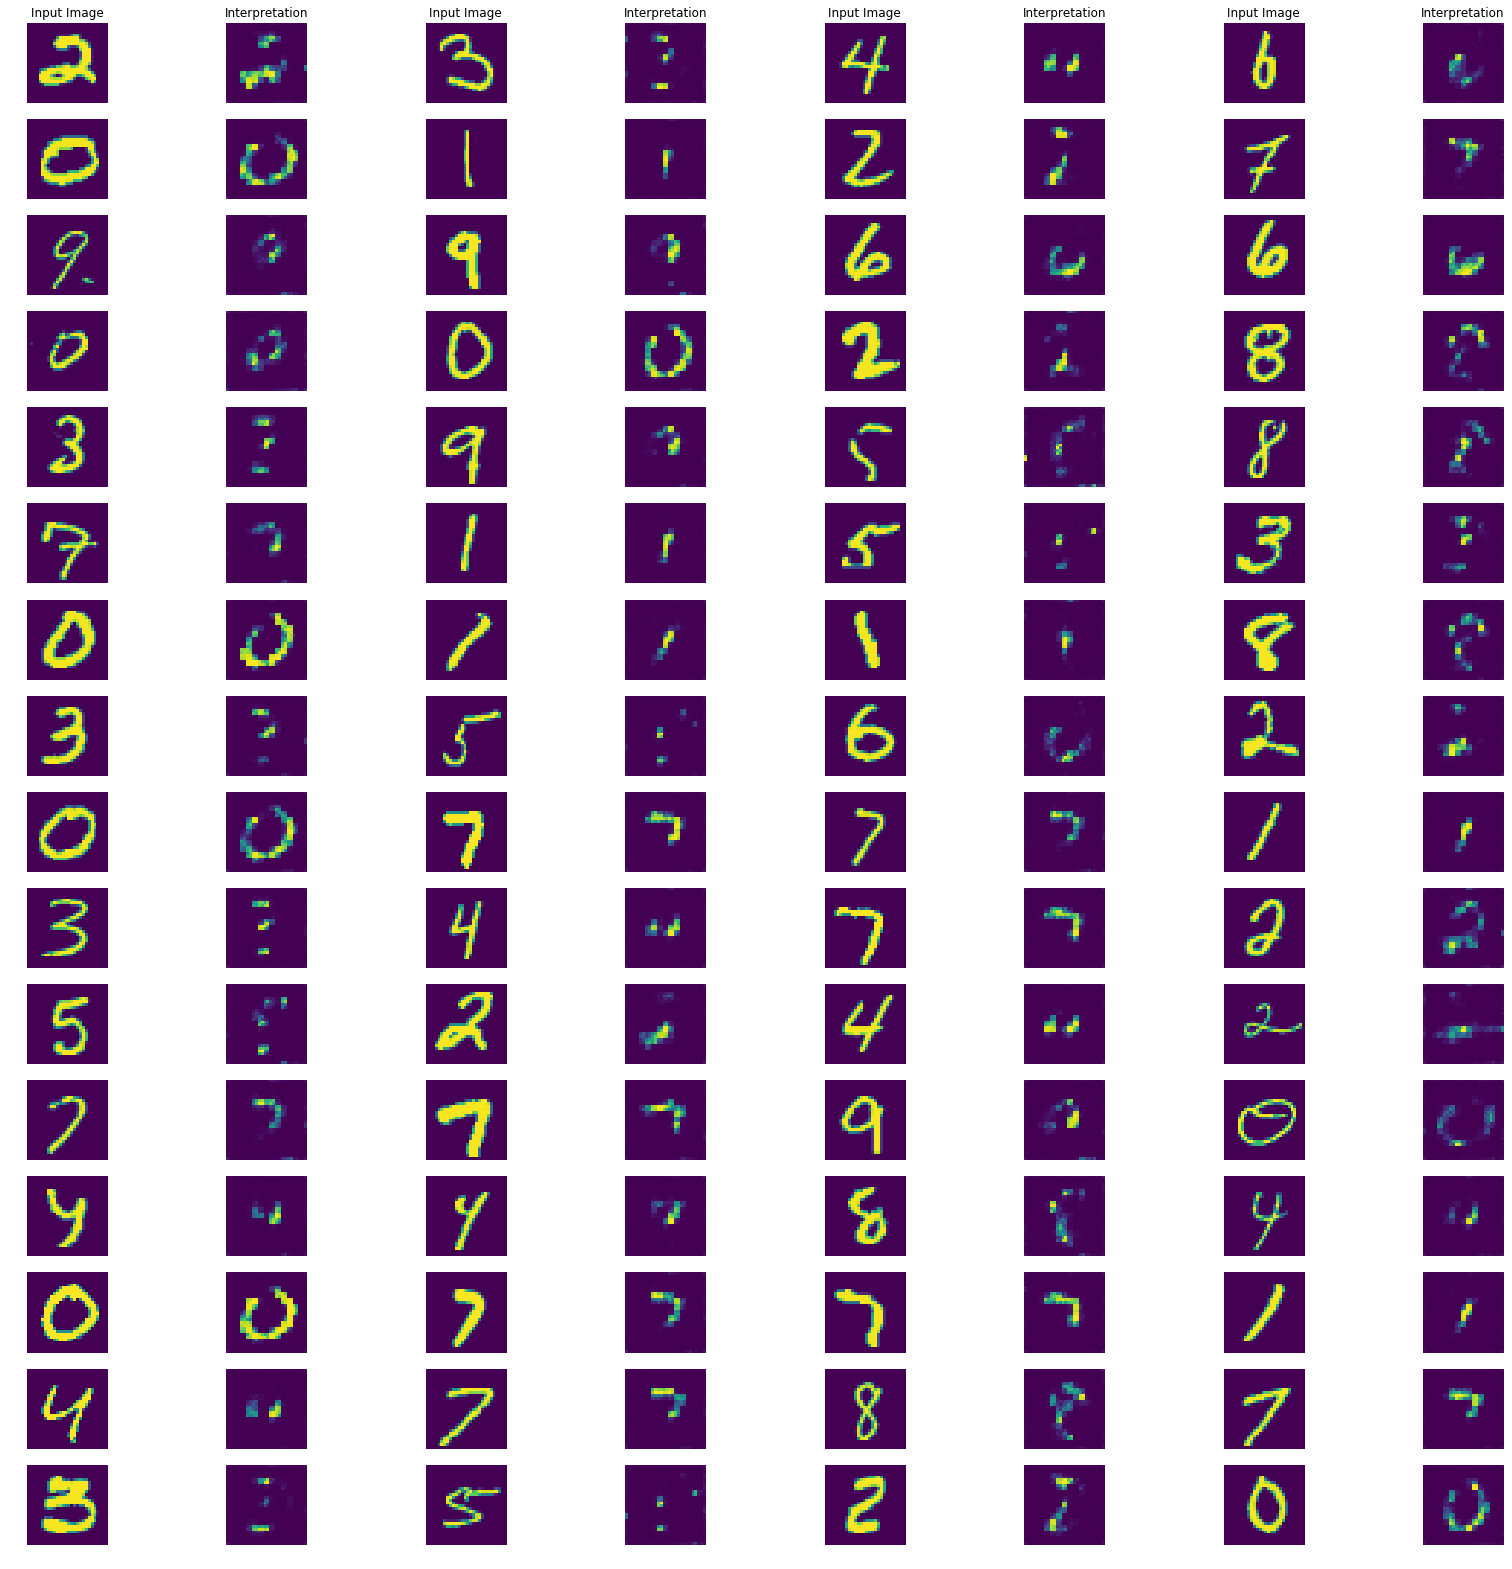

<Figure size 1440x1440 with 0 Axes>

In [5]:
import numpy as np
fig, axs = plt.subplots(16, 8, figsize=(28,28))
axs[0, 0].set_title('Input Image')
axs[0, 2].set_title('Input Image')
axs[0, 4].set_title('Input Image')
axs[0, 6].set_title('Input Image')
axs[0, 1].set_title('Interpretation')
axs[0, 3].set_title('Interpretation')
axs[0, 5].set_title('Interpretation')
axs[0, 7].set_title('Interpretation')

fig= plt.figure(figsize=(20, 20))

for j in range(0,4):
    for i in range(0,16):
        tests_figs = tests[i+j*16].reshape((28,28))
        axs[i, 2*j].imshow(tests_figs)
        axs[i, 2*j].axis('off')

        
for j in range(0,4):
    for i in range(0,16):
        interprets_figs = interprets[i+j*16].reshape((28,28))
        axs[i, 2*j+1].imshow(interprets_figs)
        axs[i, 2*j+1].axis('off')        
plt.show()